## Naive Bayes Classifier 

This notebook contains the naive bayes classifier on the collected data.

Table of Content:
* **1. Import required packages**
* **2. Import files**
* **3. Check the imbalance in the target feature**
* 3.1 Undersampling the majority class
* **4. Word Frequency**
* 4.1 Bag of Words
* 4.2 TF-IDF
* **5. Naive Bayes Classifier**
* 5.1 Define the target and explanatory variable, cross validation
* 5.2 Build the model with Sklearn pipeline
* 5.3 Evaluation of the model 
* *5.3.1 Modell Accuracy*
* *5.3.2 Confusion Matrix*
* *5.3.3 ROC curve*
* **6. Iterable modell building**
* 6.1 Visualization of the results

### 1. Import required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### 2. Import files

In [2]:
abt_covid = pd.read_pickle('C:/Users/molna/Desktop/Szakdolgozat/adatok/abt_covid_featured.pkl')

print("ABT table has {} rows and {} columns".format(len(abt_covid), len(abt_covid.columns)))

ABT table has 63633 rows and 50 columns


In [3]:
# select only the relevant features for the modelling
data = abt_covid[["dezinf", "title_lemmas", "text_lemmas"]]

### 3. Check the imbalance in the target feature

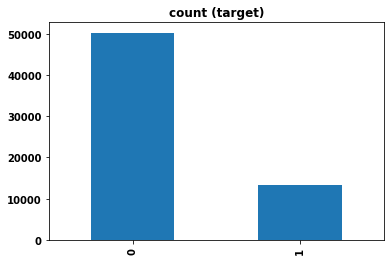

In [4]:
data['dezinf'].value_counts().plot(kind='bar', title='count (target)')

### 3.1 Undersampling the majority class

In [5]:
class_count_0, class_count_1 = data['dezinf'].value_counts()

In [6]:
class_0 = data[data['dezinf'] == 0]
class_1 = data[data['dezinf'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (50358, 3)
class 1: (13275, 3)


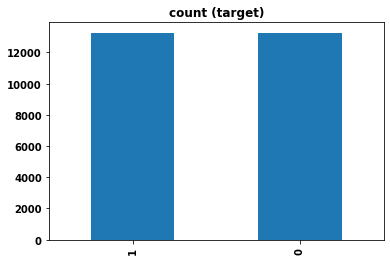

In [7]:
class_0_under = class_0.sample(class_count_1)

data_under = pd.concat([class_0_under, class_1], axis=0)

data_under['dezinf'].value_counts().plot(kind='bar', title='count (target)')

In [8]:
data = data_under

### 4. Word Frequency

In [9]:
def dummy(doc):
    return doc

#### 4.1 Bag of Words

In [10]:
count_vect = CountVectorizer(tokenizer=dummy, preprocessor=dummy,)

In [11]:
word_count_matrix = count_vect.fit_transform(data_under["text_lemmas"])

In [12]:
word_count_matrix

<26550x192321 sparse matrix of type '<class 'numpy.int64'>'
	with 3926512 stored elements in Compressed Sparse Row format>

#### 4.2 TF-IDF
(i.e Term Frequency times inverse document frequency)

In [13]:
tf_idf = TfidfTransformer()
tf_idf.fit(word_count_matrix)
tf_idf.idf_

array([ 9.39506322,  6.81737484,  8.8842376 , ..., 10.49367551,
       10.49367551, 10.49367551])

In [14]:
idf = pd.DataFrame(tf_idf.idf_, index=count_vect.get_feature_names(), columns=['idf_weight'])
idf.sort_values(by='idf_weight')

C:\Users\molna\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,idf_weight
koronavírus,1.290712
járvány,1.507667
ember,1.889846
tud,1.925314
ország,2.065641
...,...
kivéreztetné,10.493676
kivéreztetheti,10.493676
kivéreztethet,10.493676
kiválasztható,10.493676


### 5. Naive Bayes Classifier

#### 5.1 Define the target and explanatory variable, cross validation

In [15]:
X = data_under['text_lemmas']
y = data_under['dezinf']

In [16]:
# split data into 80% training and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # , random_state=42

#### 5.2 Build the model with Sklearn pipeline

In [17]:
pipe = Pipeline([
    ('vector', CountVectorizer(tokenizer=dummy, preprocessor=dummy)), 
    ('tfidf', TfidfTransformer()), 
    ('mulNB', MultinomialNB(alpha=0.4))
])

In [18]:
bayes_model = pipe.fit(X_train, y_train)

#### 5.3 Evaluation of the model

#### 5.3.1 Modell Accuracy

In [19]:
predicted = bayes_model.predict(X_test)

score = round(pipe.score(X_test, y_test), 2)

print("The Accuracy of the naive bayes model on the article text is: {} % with the balanced dataset".format(score))

The Accuracy of the naive bayes model on the article text is: 0.83 % with the balanced dataset


**The Accuracy of the naive bayes modell on the article text is 0.82% with the unbalances dataset.** 

#### 5.3.2 Confusion Matrix

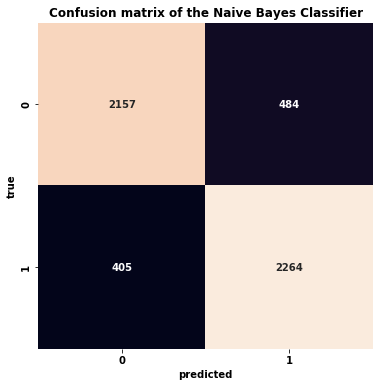

Failure first row (%):  22.44 %
Failure second row (%):  17.89 %


In [20]:
cm = confusion_matrix(y_test, predicted)
plt.figure(figsize = (6,6))
sns.heatmap(cm, annot=True, cbar=False, fmt="g")
plt.title('Confusion matrix of the Naive Bayes Classifier')
plt.xlabel("predicted")
plt.ylabel("true")

plt.show()

print("Failure first row (%): ", round(confusion_matrix(y_test, predicted)[0,1]/confusion_matrix(y_test, predicted)[0,0]*100,2),"%")
print("Failure second row (%): ", round(confusion_matrix(y_test, predicted)[1,0]/confusion_matrix(y_test, predicted)[1,1]*100,2),"%")

The model classifies the 77,69% of the mainstream articles in the good place.
And 84,2 % of the dezinformational articles in the good place.

#### 5.3.3 ROC curve

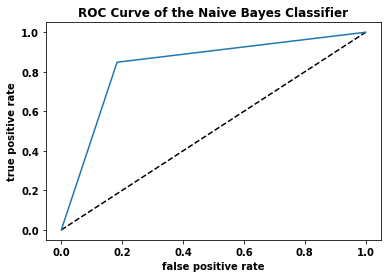

The AUC score of the Naive Bayes Classifier: 0.83


In [21]:
fpr, tpr, thresholds = roc_curve(y_test, predicted)

# plot the diagonal line
plt.plot([0,1],[0,1],'k--') 
# plot the ROC curve
plt.plot(fpr, tpr, label='NB') 
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC Curve of the Naive Bayes Classifier')
plt.show()

print("The AUC score of the Naive Bayes Classifier: {}".format(round(roc_auc_score(y_test, predicted), 2)))

In [22]:
prediction = pipe.predict(data_under['text_lemmas'])

In [23]:
data_under["prediction"] = prediction

In [24]:
data_under.head()

,dezinf,title_lemmas,text_lemmas,prediction
"""2728""",0,"[korcsolya, világbajnokság, töröl, koronavírus]","[szakág, elhalasztott, világbajnokság, végleg,...",0
"""81105""",0,"[kiüt, spanyol, szlovák, svéd, csoportelső]","[labdarúgó, európa, bajnokság, csoport, spanyo...",0
"""49096""",0,"[visszajár, szállás, fizetett, előleg, korláto...","[visszajár, előleg, érvényesíthető, kötbér, fo...",0
"""6034""",0,"[lakcímkártya, dönt, mehet, nyaraló]","[csütörtök, este, jelent, orbán, viktor, vidék...",1
"""16456""",0,"[újranyit, szálloda, fürdő, ausztria]","[szigorú, óvintézkedés, nyithat, szálloda, fit...",0


### 6. Iterable modell building

In [34]:
iter = 50

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['model_runs', 'fpr', 'tpr', 'acc', 'auc'])

for i in range(0, iter): 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # , random_state=42
    
    pipe = Pipeline([
        ('vector', CountVectorizer(tokenizer=dummy, preprocessor=dummy)), 
        ('tfidf', TfidfTransformer()), 
        ('mulNB', MultinomialNB(alpha=0.4))
        ])
    
    bayes_model = pipe.fit(X_train, y_train)
        
    predicted = bayes_model.predict(X_test)
    
    yproba = bayes_model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)

    acc = round(pipe.score(X_test, y_test), 6)
    
    auc = round(roc_auc_score(y_test, predicted), 6)
    
    result_table = result_table.append({'model_runs': i,
                                        'fpr': fpr, 
                                        'tpr': tpr, 
                                        'acc': acc,
                                        'auc':auc},
                                       ignore_index=True)


# Set name of the classifiers as index labels
result_table.set_index('model_runs', inplace=True)

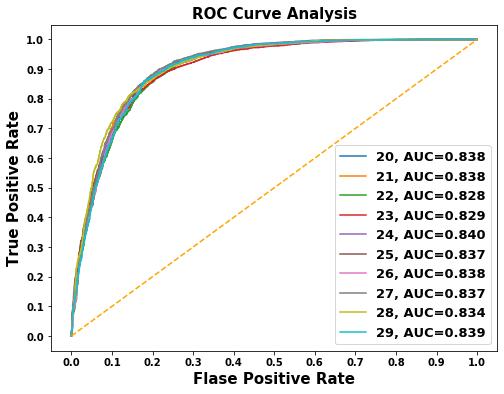

In [41]:
fig = plt.figure(figsize=(8,6))

for i in result_table[20:30].index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [42]:
# mean AUC score of 100 runs
print(result_table['auc'].mean())

0.83651662


#### 6.1 Visualization of the results

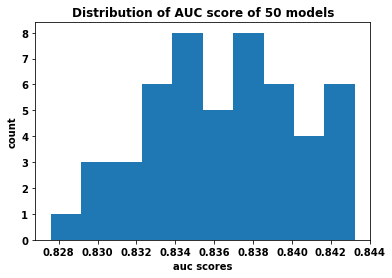

In [35]:

plt.hist(result_table['auc'])
plt.xlabel('auc scores') 
plt.ylabel('count') 
  
# displaying the title
plt.title("Distribution of AUC score of 50 models")
plt.show() 
